We need to present a strategic recommendation to Julia that is supported by data which she can then use for the upcoming category review however to do so we need to analyse the data to understand the current purchasing trends and behaviours. The client is particularly interested in customer segments and their chip purchasing behaviour. Consider what metrics would help describe the customers’ purchasing behaviour.

In [118]:
import numpy as np
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from scipy.stats import ttest_ind
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import re
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read data
transaction=pd.read_excel('QVI_transaction_data.xlsx')
customer=pd.read_csv('QVI_purchase_behaviour.csv')

In [3]:
# Print first 10 rows
transaction.head()

DATE  STORE_NBR  LYLTY_CARD_NBR  TXN_ID  PROD_NBR  \
0  43390          1            1000       1         5   
1  43599          1            1307     348        66   
2  43605          1            1343     383        61   
3  43329          2            2373     974        69   
4  43330          2            2426    1038       108   

                                  PROD_NAME  PROD_QTY  TOT_SALES  
0    Natural Chip        Compny SeaSalt175g         2        6.0  
1                  CCs Nacho Cheese    175g         3        6.3  
2    Smiths Crinkle Cut  Chips Chicken 170g         2        2.9  
3    Smiths Chip Thinly  S/Cream&Onion 175g         5       15.0  
4  Kettle Tortilla ChpsHny&Jlpno Chili 150g         3       13.8

In [4]:
customer.head()

LYLTY_CARD_NBR               LIFESTAGE PREMIUM_CUSTOMER
0            1000   YOUNG SINGLES/COUPLES          Premium
1            1002   YOUNG SINGLES/COUPLES       Mainstream
2            1003          YOUNG FAMILIES           Budget
3            1004   OLDER SINGLES/COUPLES       Mainstream
4            1005  MIDAGE SINGLES/COUPLES       Mainstream

Lets merge the transaction and purchase behavior ("customers") datasets on loyalty card number "LYLTY_CARD_NUMBER"  using a right join for further exploration

In [5]:
df = pd.merge(customer, transaction, on="LYLTY_CARD_NBR", how="right")
df.head()

LYLTY_CARD_NBR               LIFESTAGE PREMIUM_CUSTOMER   DATE  STORE_NBR  \
0            1000   YOUNG SINGLES/COUPLES          Premium  43390          1   
1            1307  MIDAGE SINGLES/COUPLES           Budget  43599          1   
2            1343  MIDAGE SINGLES/COUPLES           Budget  43605          1   
3            2373  MIDAGE SINGLES/COUPLES           Budget  43329          2   
4            2426  MIDAGE SINGLES/COUPLES           Budget  43330          2   

   TXN_ID  PROD_NBR                                 PROD_NAME  PROD_QTY  \
0       1         5    Natural Chip        Compny SeaSalt175g         2   
1     348        66                  CCs Nacho Cheese    175g         3   
2     383        61    Smiths Crinkle Cut  Chips Chicken 170g         2   
3     974        69    Smiths Chip Thinly  S/Cream&Onion 175g         5   
4    1038       108  Kettle Tortilla ChpsHny&Jlpno Chili 150g         3   

   TOT_SALES  
0        6.0  
1        6.3  
2        2.9  
3       15.0  
4       13.8

In [6]:
#checking the total number of columns and rows
df.shape

(264836, 10)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 264836 entries, 0 to 264835
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264836 non-null  int64  
 1   LIFESTAGE         264836 non-null  object 
 2   PREMIUM_CUSTOMER  264836 non-null  object 
 3   DATE              264836 non-null  int64  
 4   STORE_NBR         264836 non-null  int64  
 5   TXN_ID            264836 non-null  int64  
 6   PROD_NBR          264836 non-null  int64  
 7   PROD_NAME         264836 non-null  object 
 8   PROD_QTY          264836 non-null  int64  
 9   TOT_SALES         264836 non-null  float64
dtypes: float64(1), int64(6), object(3)
memory usage: 22.2+ MB


In [8]:
# correcting DATE datatype from int to date
df["DATE"] = pd.to_datetime(df["DATE"], origin="1899-12-30",unit="D")
df['DATE'].head()

0   2018-10-17
1   2019-05-14
2   2019-05-20
3   2018-08-17
4   2018-08-18
Name: DATE, dtype: datetime64[ns]

In [9]:
df["PROD_NAME"].unique()

array(['Natural Chip        Compny SeaSalt175g',
       'CCs Nacho Cheese    175g',
       'Smiths Crinkle Cut  Chips Chicken 170g',
       'Smiths Chip Thinly  S/Cream&Onion 175g',
       'Kettle Tortilla ChpsHny&Jlpno Chili 150g',
       'Old El Paso Salsa   Dip Tomato Mild 300g',
       'Smiths Crinkle Chips Salt & Vinegar 330g',
       'Grain Waves         Sweet Chilli 210g',
       'Doritos Corn Chip Mexican Jalapeno 150g',
       'Grain Waves Sour    Cream&Chives 210G',
       'Kettle Sensations   Siracha Lime 150g',
       'Twisties Cheese     270g', 'WW Crinkle Cut      Chicken 175g',
       'Thins Chips Light&  Tangy 175g', 'CCs Original 175g',
       'Burger Rings 220g', 'NCC Sour Cream &    Garden Chives 175g',
       'Doritos Corn Chip Southern Chicken 150g',
       'Cheezels Cheese Box 125g', 'Smiths Crinkle      Original 330g',
       'Infzns Crn Crnchers Tangy Gcamole 110g',
       'Kettle Sea Salt     And Vinegar 175g',
       'Smiths Chip Thinly  Cut Original 175g', 'K

In [10]:
# Extracting pack size from the Product
import re
def find_number(text):
    num = re.findall(r'[0-9]+',text)
    return " ".join(num)
df['pack_size']=df['PROD_NAME'].apply(lambda x: find_number(x))
df

LYLTY_CARD_NBR               LIFESTAGE PREMIUM_CUSTOMER       DATE  \
0                 1000   YOUNG SINGLES/COUPLES          Premium 2018-10-17   
1                 1307  MIDAGE SINGLES/COUPLES           Budget 2019-05-14   
2                 1343  MIDAGE SINGLES/COUPLES           Budget 2019-05-20   
3                 2373  MIDAGE SINGLES/COUPLES           Budget 2018-08-17   
4                 2426  MIDAGE SINGLES/COUPLES           Budget 2018-08-18   
...                ...                     ...              ...        ...   
264831          272319   YOUNG SINGLES/COUPLES          Premium 2019-03-09   
264832          272358   YOUNG SINGLES/COUPLES          Premium 2018-08-13   
264833          272379   YOUNG SINGLES/COUPLES          Premium 2018-11-06   
264834          272379   YOUNG SINGLES/COUPLES          Premium 2018-12-27   
264835          272380   YOUNG SINGLES/COUPLES          Premium 2018-09-22   

        STORE_NBR  TXN_ID  PROD_NBR                                 PROD_NAME  \
0               1       1         5    Natural Chip        Compny SeaSalt175g   
1               1     348        66                  CCs Nacho Cheese    175g   
2               1     383        61    Smiths Crinkle Cut  Chips Chicken 170g   
3               2     974        69    Smiths Chip Thinly  S/Cream&Onion 175g   
4               2    1038       108  Kettle Tortilla ChpsHny&Jlpno Chili 150g   
...           ...     ...       ...                                       ...   
264831        272  270088        89   Kettle Sweet Chilli And Sour Cream 175g   
264832        272  270154        74             Tostitos Splash Of  Lime 175g   
264833        272  270187        51                  Doritos Mexicana    170g   
264834        272  270188        42   Doritos Corn Chip Mexican Jalapeno 150g   
264835        272  270189        74             Tostitos Splash Of  Lime 175g   

        PROD_QTY  TOT_SALES pack_size  
0              2        6.0       175  
1              3        6.3       175  
2              2        2.9       170  
3              5       15.0       175  
4              3       13.8       150  
...          ...        ...       ...  
264831         2       10.8       175  
264832         1        4.4       175  
264833         2        8.8       170  
264834         2        7.8       150  
264835         2        8.8       175  

[264836 rows x 11 columns]

In [13]:
# Split product names as well as remove all digits and special characters such as '&'
import re
 prn= df["PROD_NAME"].str.replace('([0-9]+[gG])','').str.replace('[^\w]', ' ').str.split()

# Calculate the frequency grouped by words and sort them
prf = pd.value_counts([word for name in prn
                                for word in name]).sort_values(ascending=False)
prf.head()

Chips     49770
Kettle    41288
Smiths    28860
Salt      27976
Cheese    27890
dtype: int64

In [14]:
# Remove salsa from the list of products n other to concentrate only on chips which is our core focus in this analysis
df = df[~df["PROD_NAME"].str.contains("[Ss]alsa")]

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246742 entries, 0 to 264835
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   LYLTY_CARD_NBR    246742 non-null  int64         
 1   LIFESTAGE         246742 non-null  object        
 2   PREMIUM_CUSTOMER  246742 non-null  object        
 3   DATE              246742 non-null  datetime64[ns]
 4   STORE_NBR         246742 non-null  int64         
 5   TXN_ID            246742 non-null  int64         
 6   PROD_NBR          246742 non-null  int64         
 7   PROD_NAME         246742 non-null  object        
 8   PROD_QTY          246742 non-null  int64         
 9   TOT_SALES         246742 non-null  float64       
 10  pack_size         246742 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(5), object(4)
memory usage: 22.6+ MB


In [19]:
df.isnull().sum()

LYLTY_CARD_NBR      0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
DATE                0
STORE_NBR           0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
pack_size           0
dtype: int64

In [20]:
df.describe()

LYLTY_CARD_NBR      STORE_NBR        TXN_ID       PROD_NBR  \
count    2.467420e+05  246742.000000  2.467420e+05  246742.000000   
mean     1.355310e+05     135.051098  1.351311e+05      56.351789   
std      8.071528e+04      76.787096  7.814772e+04      33.695428   
min      1.000000e+03       1.000000  1.000000e+00       1.000000   
25%      7.001500e+04      70.000000  6.756925e+04      26.000000   
50%      1.303670e+05     130.000000  1.351830e+05      53.000000   
75%      2.030840e+05     203.000000  2.026538e+05      87.000000   
max      2.373711e+06     272.000000  2.415841e+06     114.000000   

            PROD_QTY      TOT_SALES  
count  246742.000000  246742.000000  
mean        1.908062       7.321322  
std         0.659831       3.077828  
min         1.000000       1.700000  
25%         2.000000       5.800000  
50%         2.000000       7.400000  
75%         2.000000       8.800000  
max       200.000000     650.000000

In [21]:
df.sort_values(by="PROD_QTY", ascending=False).head()

LYLTY_CARD_NBR       LIFESTAGE PREMIUM_CUSTOMER       DATE  STORE_NBR  \
69763           226000  OLDER FAMILIES          Premium 2019-05-20        226   
69762           226000  OLDER FAMILIES          Premium 2018-08-19        226   
135225           46296        RETIREES           Budget 2019-05-15         46   
69523            71142  OLDER FAMILIES          Premium 2019-05-15         71   
69502            55144  OLDER FAMILIES          Premium 2018-08-18         55   

        TXN_ID  PROD_NBR                         PROD_NAME  PROD_QTY  \
69763   226210         4  Dorito Corn Chp     Supreme 380g       200   
69762   226201         4  Dorito Corn Chp     Supreme 380g       200   
135225   42138        81   Pringles Original   Crisps 134g         5   
69523    69852        96    WW Original Stacked Chips 160g         5   
69502    49328        44    Thins Chips Light&  Tangy 175g         5   

        TOT_SALES pack_size  
69763       650.0       380  
69762       650.0       380  
135225       18.5       134  
69523         9.5       160  
69502        16.5       175

In [26]:
# Create a box plot for 'PROD_QTY' using Plotly
fig1 = px.box(df, y='PROD_QTY', title='Box Plot for PROD_QTY')

# Create a box plot for 'TOT_SALES' using Plotly
fig2 = px.box(df, y='TOT_SALES', title='Box Plot for TOT_SALES')

# If you want to create box plots for all numerical columns, you can do so using a loop
numerical_columns = ['PROD_QTY', 'TOT_SALES']

# Create subplots for all numerical columns
fig = make_subplots ( rows=1, cols=len(numerical_columns), subplot_titles=numerical_columns)

for i, col in enumerate(numerical_columns):
    fig.add_trace(go.Box(y=df[col], name=col), row=1, col=i + 1)

fig.update_layout(title_text="Box Plots for Numerical Columns")

# Show the plots
fig.show()


In [27]:
ndf = df[df['LYLTY_CARD_NBR'] != 226000]


In [37]:
# Create a summary of transaction count by date
ndf['DATE'].describe()

count                  246740
unique                    364
top       2018-12-24 00:00:00
freq                      865
first     2018-07-01 00:00:00
last      2019-06-30 00:00:00
Name: DATE, dtype: object

In [38]:
pd.date_range(start=ndf["DATE"].min(), end=ndf["DATE"].max()).difference(ndf["DATE"])

DatetimeIndex(['2018-12-25'], dtype='datetime64[ns]', freq=None)

In [45]:
# Descriptive statistics of PACK_SIZE
ndf["pack_size"].describe()

count     246740
unique        20
top          175
freq       66390
Name: pack_size, dtype: object

In [59]:
fig = px.histogram(ndf, x="pack_size", nbins=10)

fig.update_layout(
    title="Histogram of Transactions, by Pack Size",
    xaxis_title="Pack Size",
    yaxis_title="Number of Transactions",)

fig.show()

In [51]:
# Create column for brand names
ndf['Brand Name'] = ndf['PROD_NAME'].str.split(' ').str[0]

In [52]:
# Check for any duplication or similar brands
ndf['Brand Name'].value_counts()

Kettle        41288
Smiths        27390
Pringles      25102
Doritos       22041
Thins         14075
RRD           11894
Infuzions     11057
WW            10320
Cobs           9693
Tostitos       9471
Twisties       9454
Tyrrells       6442
Grain          6272
Natural        6050
Cheezels       4603
CCs            4551
Red            4427
Dorito         3183
Infzns         3144
Smith          2963
Cheetos        2927
Snbts          1576
Burger         1564
Woolworths     1516
GrnWves        1468
Sunbites       1432
NCC            1419
French         1418
Name: Brand Name, dtype: int64

In [53]:
ndf['Brand Name'] = ndf['Brand Name'].str.replace('Red','RRD')
ndf['Brand Name'] = ndf['Brand Name'].str.replace('Woolworths','WW')
ndf['Brand Name'] = ndf['Brand Name'].str.replace('INFUZIONS','INFZNS')
ndf['Brand Name'] = ndf['Brand Name'].str.replace('SMITHS','SMITH')
ndf['Brand Name'] = ndf['Brand Name'].str.replace('SUNBITES','SNBTS')
ndf['Brand Name'] = ndf['Brand Name'].str.replace('DORITOS','DORITO')
ndf['Brand Name'] = ndf['Brand Name'].str.replace('GRNWVES','GRAIN')

In [54]:
ndf['Brand Name'].value_counts()

Kettle       41288
Smiths       27390
Pringles     25102
Doritos      22041
RRD          16321
Thins        14075
WW           11836
Infuzions    11057
Cobs          9693
Tostitos      9471
Twisties      9454
Tyrrells      6442
Grain         6272
Natural       6050
Cheezels      4603
CCs           4551
Dorito        3183
Infzns        3144
Smith         2963
Cheetos       2927
Snbts         1576
Burger        1564
GrnWves       1468
Sunbites      1432
NCC           1419
French        1418
Name: Brand Name, dtype: int64

In [57]:
fig = px.bar(ndf["Brand Name"].value_counts().reset_index(), x="Brand Name", y="index", orientation="h")

fig.update_layout(
    title="Brand Name Counts",
    xaxis_title="Count",
    yaxis_title="Brand Name",)

fig.show()


-Who spends the most on chips (total sales), describing customers by lifestage

-How premium their general purchasing behaviour is

-How many customers are in each segment

-How many chips are bought per customer by segment

-What's the average chip price by customer segment

In [68]:
grouped_sales = pd.DataFrame(ndf.groupby(["LIFESTAGE", "PREMIUM_CUSTOMER"])["TOT_SALES"].agg(["sum", "mean"]))
grouped_sales.sort_values(ascending=False, by="sum")

sum      mean
LIFESTAGE              PREMIUM_CUSTOMER                     
OLDER FAMILIES         Budget            156863.75  7.291241
YOUNG SINGLES/COUPLES  Mainstream        147582.20  7.551279
RETIREES               Mainstream        145168.95  7.269352
YOUNG FAMILIES         Budget            129717.95  7.302705
OLDER SINGLES/COUPLES  Budget            127833.60  7.444305
                       Mainstream        124648.50  7.306049
                       Premium           123537.55  7.459997
RETIREES               Budget            105916.30  7.445786
OLDER FAMILIES         Mainstream         96413.55  7.281440
RETIREES               Premium            91296.65  7.461315
YOUNG FAMILIES         Mainstream         86338.25  7.226772
MIDAGE SINGLES/COUPLES Mainstream         84734.25  7.637156
YOUNG FAMILIES         Premium            78571.70  7.285951
OLDER FAMILIES         Premium            75242.60  7.232779
YOUNG SINGLES/COUPLES  Budget             57122.10  6.663023
MIDAGE SINGLES/COUPLES Premium            54443.85  7.152371
YOUNG SINGLES/COUPLES  Premium            39052.30  6.673325
MIDAGE SINGLES/COUPLES Budget             33345.70  7.108442
NEW FAMILIES           Budget             20607.45  7.297256
                       Mainstream         15979.70  7.313364
                       Premium            10760.80  7.231720

In [69]:
grouped_sales["sum"].sum()

1805177.7

<Axes: ylabel='LIFESTAGE,PREMIUM_CUSTOMER'>

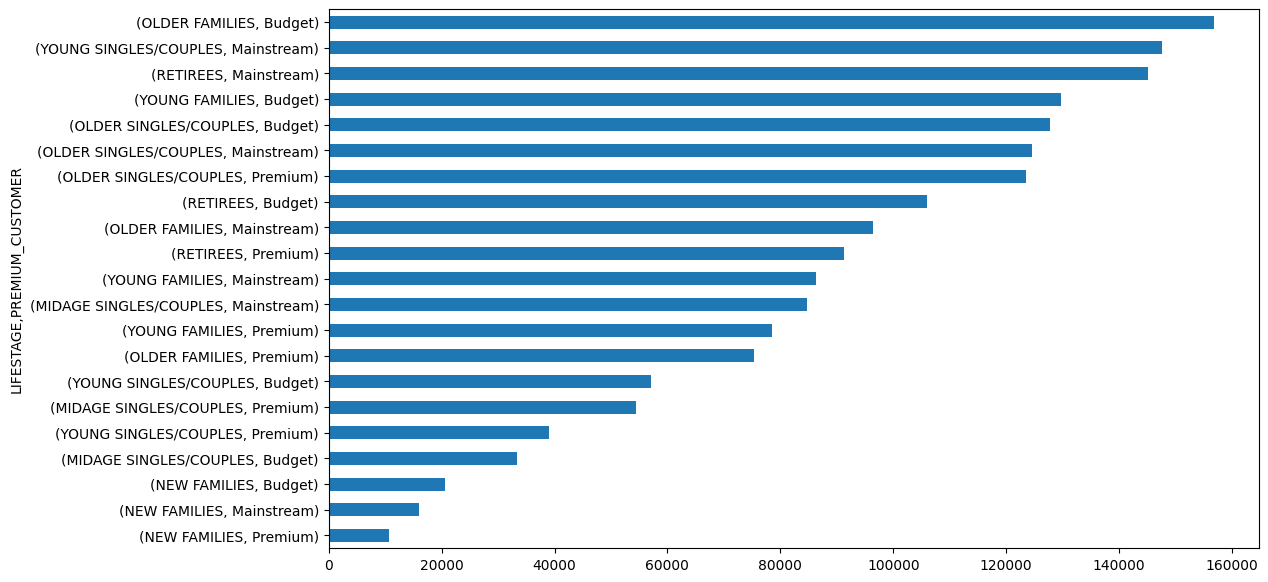

In [72]:
grouped_sales["sum"].sort_values().plot.barh(figsize=(12,7))


In [70]:
fig = px.bar(grouped_sales, x="sum", y=grouped_sales.index.get_level_values("LIFESTAGE"),
             color=grouped_sales.index.get_level_values("PREMIUM_CUSTOMER"),
             orientation='h', text=grouped_sales["sum"])

fig.update_traces(marker_line_width=1, marker_line_color="black")
fig.update_layout(title="Total Sales per Lifestage", xaxis_title="TOTAL SALES", yaxis_title="LIFESTAGE")
fig.show()


In [74]:
stage_agg_prem = ndf.groupby("LIFESTAGE")["PREMIUM_CUSTOMER"].agg(pd.Series.mode).sort_values()
print("Top contributor per LIFESTAGE by PREMIUM category")
print(stage_agg_prem)

Top contributor per LIFESTAGE by PREMIUM category
LIFESTAGE
NEW FAMILIES                  Budget
OLDER FAMILIES                Budget
OLDER SINGLES/COUPLES         Budget
YOUNG FAMILIES                Budget
MIDAGE SINGLES/COUPLES    Mainstream
RETIREES                  Mainstream
YOUNG SINGLES/COUPLES     Mainstream
Name: PREMIUM_CUSTOMER, dtype: object


In [75]:
unique_cust = ndf.groupby(["LIFESTAGE", "PREMIUM_CUSTOMER"])["LYLTY_CARD_NBR"].nunique().sort_values(ascending=False)
pd.DataFrame(unique_cust)

LYLTY_CARD_NBR
LIFESTAGE              PREMIUM_CUSTOMER                
YOUNG SINGLES/COUPLES  Mainstream                  7917
RETIREES               Mainstream                  6358
OLDER SINGLES/COUPLES  Mainstream                  4858
                       Budget                      4849
                       Premium                     4682
OLDER FAMILIES         Budget                      4611
RETIREES               Budget                      4385
YOUNG FAMILIES         Budget                      3953
RETIREES               Premium                     3812
YOUNG SINGLES/COUPLES  Budget                      3647
MIDAGE SINGLES/COUPLES Mainstream                  3298
OLDER FAMILIES         Mainstream                  2788
YOUNG FAMILIES         Mainstream                  2685
YOUNG SINGLES/COUPLES  Premium                     2480
YOUNG FAMILIES         Premium                     2398
MIDAGE SINGLES/COUPLES Premium                     2369
OLDER FAMILIES         Premium                     2231
MIDAGE SINGLES/COUPLES Budget                      1474
NEW FAMILIES           Budget                      1087
                       Mainstream                   830
                       Premium                      575

<Axes: ylabel='LIFESTAGE,PREMIUM_CUSTOMER'>

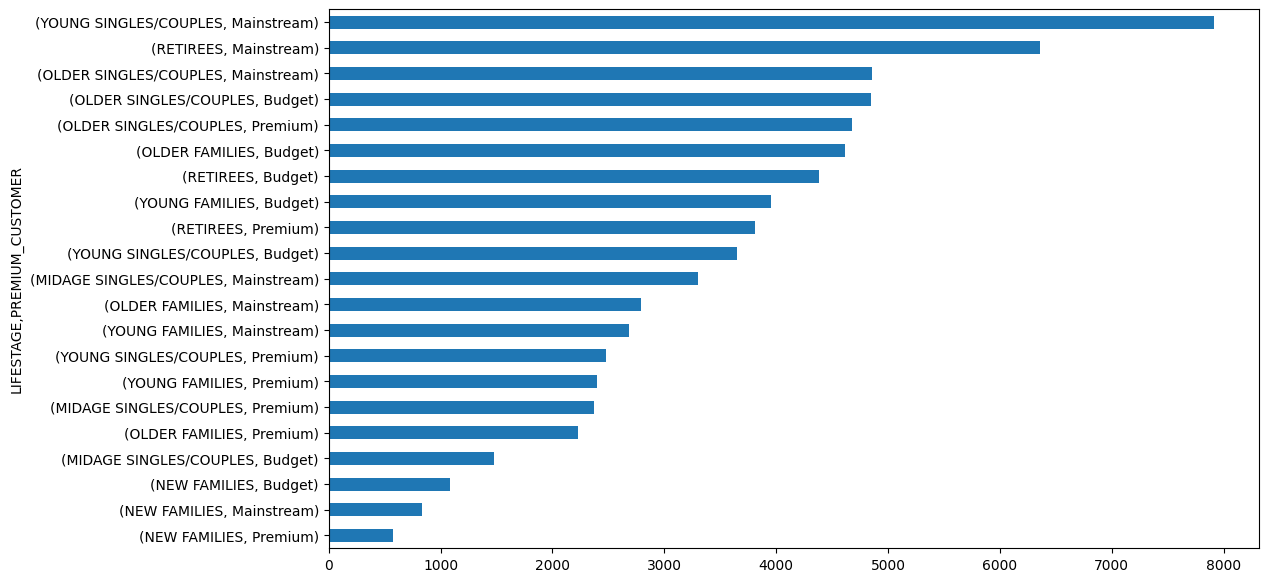

In [76]:
unique_cust.sort_values().plot.barh(figsize=(12,7))

In [85]:
freq_per_cust = ndf.groupby(["LYLTY_CARD_NBR", "LIFESTAGE", "PREMIUM_CUSTOMER"]).count()["DATE"]
freq_per_cust.groupby(["LIFESTAGE", "PREMIUM_CUSTOMER"]).agg(["mean", "count"]).sort_values(ascending=False, by="mean")

mean  count
LIFESTAGE              PREMIUM_CUSTOMER                 
OLDER FAMILIES         Mainstream        4.749283   2788
                       Budget            4.665799   4611
                       Premium           4.662931   2231
YOUNG FAMILIES         Premium           4.497081   2398
                       Budget            4.493549   3953
                       Mainstream        4.449534   2685
OLDER SINGLES/COUPLES  Budget            3.541349   4849
                       Premium           3.536950   4682
                       Mainstream        3.511939   4858
MIDAGE SINGLES/COUPLES Mainstream        3.364160   3298
RETIREES               Budget            3.244014   4385
MIDAGE SINGLES/COUPLES Premium           3.213170   2369
RETIREES               Premium           3.209864   3812
MIDAGE SINGLES/COUPLES Budget            3.182497   1474
RETIREES               Mainstream        3.140925   6358
NEW FAMILIES           Mainstream        2.632530    830
                       Budget            2.597976   1087
                       Premium           2.587826    575
YOUNG SINGLES/COUPLES  Mainstream        2.468612   7917
                       Premium           2.359677   2480
                       Budget            2.350699   3647

In [86]:
grouped_sales.sort_values(ascending=False, by="mean")

sum      mean
LIFESTAGE              PREMIUM_CUSTOMER                     
MIDAGE SINGLES/COUPLES Mainstream         84734.25  7.637156
YOUNG SINGLES/COUPLES  Mainstream        147582.20  7.551279
RETIREES               Premium            91296.65  7.461315
OLDER SINGLES/COUPLES  Premium           123537.55  7.459997
RETIREES               Budget            105916.30  7.445786
OLDER SINGLES/COUPLES  Budget            127833.60  7.444305
NEW FAMILIES           Mainstream         15979.70  7.313364
OLDER SINGLES/COUPLES  Mainstream        124648.50  7.306049
YOUNG FAMILIES         Budget            129717.95  7.302705
NEW FAMILIES           Budget             20607.45  7.297256
OLDER FAMILIES         Budget            156863.75  7.291241
YOUNG FAMILIES         Premium            78571.70  7.285951
OLDER FAMILIES         Mainstream         96413.55  7.281440
RETIREES               Mainstream        145168.95  7.269352
OLDER FAMILIES         Premium            75242.60  7.232779
NEW FAMILIES           Premium            10760.80  7.231720
YOUNG FAMILIES         Mainstream         86338.25  7.226772
MIDAGE SINGLES/COUPLES Premium            54443.85  7.152371
                       Budget             33345.70  7.108442
YOUNG SINGLES/COUPLES  Premium            39052.30  6.673325
                       Budget             57122.10  6.663023

In [90]:
grouped_sales.sort_values(ascending=False, by="mean")

sum      mean
LIFESTAGE              PREMIUM_CUSTOMER                     
MIDAGE SINGLES/COUPLES Mainstream         84734.25  7.637156
YOUNG SINGLES/COUPLES  Mainstream        147582.20  7.551279
RETIREES               Premium            91296.65  7.461315
OLDER SINGLES/COUPLES  Premium           123537.55  7.459997
RETIREES               Budget            105916.30  7.445786
OLDER SINGLES/COUPLES  Budget            127833.60  7.444305
NEW FAMILIES           Mainstream         15979.70  7.313364
OLDER SINGLES/COUPLES  Mainstream        124648.50  7.306049
YOUNG FAMILIES         Budget            129717.95  7.302705
NEW FAMILIES           Budget             20607.45  7.297256
OLDER FAMILIES         Budget            156863.75  7.291241
YOUNG FAMILIES         Premium            78571.70  7.285951
OLDER FAMILIES         Mainstream         96413.55  7.281440
RETIREES               Mainstream        145168.95  7.269352
OLDER FAMILIES         Premium            75242.60  7.232779
NEW FAMILIES           Premium            10760.80  7.231720
YOUNG FAMILIES         Mainstream         86338.25  7.226772
MIDAGE SINGLES/COUPLES Premium            54443.85  7.152371
                       Budget             33345.70  7.108442
YOUNG SINGLES/COUPLES  Premium            39052.30  6.673325
                       Budget             57122.10  6.663023

In [95]:

ndf.groupby(["LIFESTAGE", "PREMIUM_CUSTOMER"])["Brand Name"].agg(pd.Series.mode).sort_values()

LIFESTAGE               PREMIUM_CUSTOMER
MIDAGE SINGLES/COUPLES  Budget              Kettle
YOUNG SINGLES/COUPLES   Budget              Kettle
YOUNG FAMILIES          Premium             Kettle
                        Mainstream          Kettle
                        Budget              Kettle
RETIREES                Premium             Kettle
                        Mainstream          Kettle
                        Budget              Kettle
OLDER SINGLES/COUPLES   Premium             Kettle
YOUNG SINGLES/COUPLES   Mainstream          Kettle
OLDER SINGLES/COUPLES   Mainstream          Kettle
OLDER FAMILIES          Premium             Kettle
                        Mainstream          Kettle
                        Budget              Kettle
NEW FAMILIES            Premium             Kettle
                        Mainstream          Kettle
                        Budget              Kettle
MIDAGE SINGLES/COUPLES  Premium             Kettle
                        Mainstream       

========== YOUNG SINGLES/COUPLES - Premium ==========
Kettle      838
Smiths      707
Pringles    537
Name: Brand Name, dtype: int64
========== YOUNG SINGLES/COUPLES - Budget ==========
Kettle      1211
Smiths      1058
Pringles     832
Name: Brand Name, dtype: int64
========== YOUNG SINGLES/COUPLES - Mainstream ==========
Kettle      3844
Pringles    2315
Doritos     2076
Name: Brand Name, dtype: int64
========== MIDAGE SINGLES/COUPLES - Premium ==========
Kettle      1206
Smiths       825
Pringles     781
Name: Brand Name, dtype: int64
========== MIDAGE SINGLES/COUPLES - Budget ==========
Kettle      713
Smiths      522
Pringles    449
Name: Brand Name, dtype: int64
========== MIDAGE SINGLES/COUPLES - Mainstream ==========
Kettle      2136
Smiths      1176
Pringles    1159
Name: Brand Name, dtype: int64
========== NEW FAMILIES - Premium ==========
Kettle      247
Pringles    165
Doritos     139
Name: Brand Name, dtype: int64
========== NEW FAMILIES - Budget ==========
Kettle      510

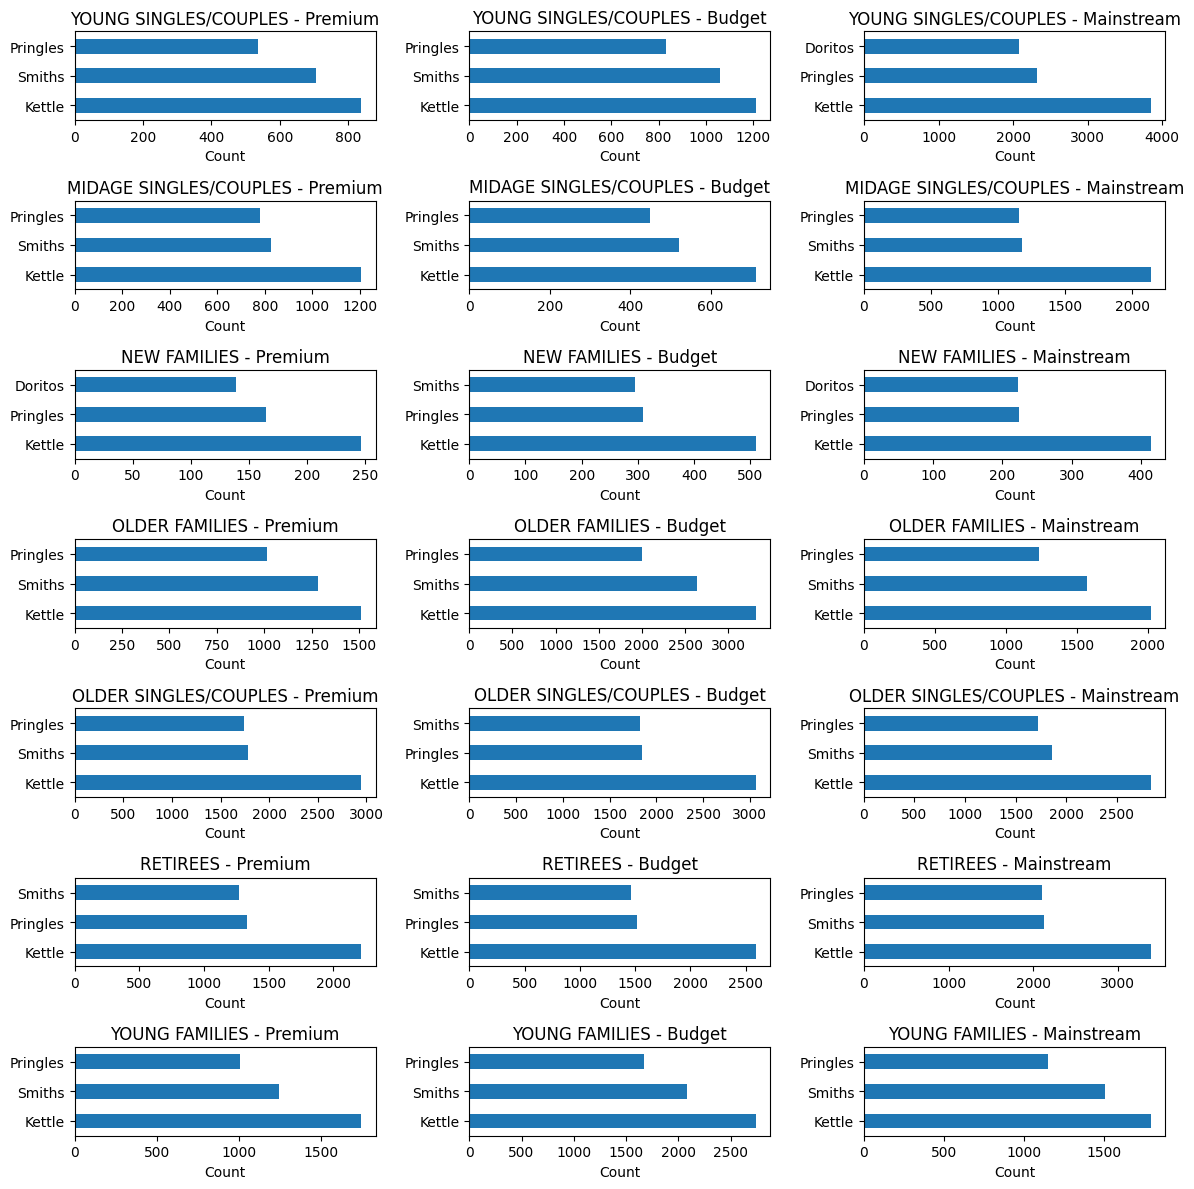

In [117]:
# Get unique LIFESTAGE and PREMIUM_CUSTOMER combinations
lifestages = ndf["LIFESTAGE"].unique()
customers = ndf["PREMIUM_CUSTOMER"].unique()

# Set the number of columns for each row of plots
num_cols = 2

# Create subplots
fig, axs = plt.subplots(len(lifestages), len(customers), figsize=(12, 12))

for i, stage in enumerate(lifestages):
    for j, prem in enumerate(customers):
        print('==========', stage, '-', prem, '==========')
        summary = ndf[(ndf["LIFESTAGE"] == stage) & (ndf["PREMIUM_CUSTOMER"] == prem)]["Brand Name"].value_counts().head(3)
        print(summary)
        ax = axs[i, j]
        summary.plot.barh(ax=ax)
        ax.set_title(f'{stage} - {prem}')
        ax.set_xlabel('Count')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


In [120]:
temp = ndf.reset_index().rename(columns = {"index": "transaction"})
temp["Segment"] = temp["LIFESTAGE"] + ' - ' + temp['PREMIUM_CUSTOMER']
segment_brand_encode = pd.concat([pd.get_dummies(temp["Segment"]), pd.get_dummies(temp["Brand Name"])], axis=1)

In [121]:
frequent_sets = apriori(segment_brand_encode, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_sets, metric="lift", min_threshold=1)

In [122]:
set_temp = temp["Segment"].unique()
rules[rules["antecedents"].apply(lambda x: list(x)).apply(lambda x: x in set_temp)]

antecedents consequents  antecedent support  \
0              (OLDER FAMILIES - Budget)    (Smiths)            0.087193   
3       (OLDER SINGLES/COUPLES - Budget)    (Kettle)            0.069596   
4      (OLDER SINGLES/COUPLES - Premium)    (Kettle)            0.067115   
7                    (RETIREES - Budget)    (Kettle)            0.057652   
8                (RETIREES - Mainstream)    (Kettle)            0.080935   
10  (YOUNG SINGLES/COUPLES - Mainstream)    (Kettle)            0.079209   

    consequent support   support  confidence      lift  leverage  conviction  \
0             0.111008  0.010700    0.122711  1.105428  0.001020    1.013340   
3             0.167334  0.012422    0.178488  1.066658  0.000776    1.013578   
4             0.167334  0.011944    0.177959  1.063495  0.000713    1.012925   
7             0.167334  0.010505    0.182214  1.088926  0.000858    1.018196   
8             0.167334  0.013723    0.169554  1.013269  0.000180    1.002674   
10            0.167334  0.015579    0.196684  1.175400  0.002325    1.036537   

    zhangs_metric  
0        0.104483  
3        0.067167  
4        0.064000  
7        0.086660  
8        0.014248  
10       0.162062

In [144]:
# Create an empty DataFrame to store the summary data
summary_table = pd.DataFrame(columns=["LIFESTAGE", "PREMIUM_CUSTOMER", "Top 3 Pack Sizes"])

# Iterate over LIFESTAGE and PREMIUM_CUSTOMER
for stage in ndf["LIFESTAGE"].unique():
    for prem in ndf["PREMIUM_CUSTOMER"].unique():
        print('==========', stage, '-', prem, '==========')
        subset = ndf[(ndf["LIFESTAGE"] == stage) & (ndf["PREMIUM_CUSTOMER"] == prem)]

        if not subset.empty:
            summary = subset["pack_size"].value_counts().head(3).sort_index()
            print(summary)
            summary_str = ", ".join([f"{size}: {count}" for size, count in summary.items()])


========== YOUNG SINGLES/COUPLES - Premium ==========
134     537
150     933
175    1618
Name: pack_size, dtype: int64
========== YOUNG SINGLES/COUPLES - Budget ==========
134     832
150    1390
175    2338
Name: pack_size, dtype: int64
========== YOUNG SINGLES/COUPLES - Mainstream ==========
134    2315
150    3080
175    4997
Name: pack_size, dtype: int64
========== MIDAGE SINGLES/COUPLES - Premium ==========
134     781
150    1207
175    2082
Name: pack_size, dtype: int64
========== MIDAGE SINGLES/COUPLES - Budget ==========
134     449
150     771
175    1277
Name: pack_size, dtype: int64
========== MIDAGE SINGLES/COUPLES - Mainstream ==========
134    1159
150    1777
175    2975
Name: pack_size, dtype: int64
========== NEW FAMILIES - Premium ==========
134    165
150    233
175    376
Name: pack_size, dtype: int64
========== NEW FAMILIES - Budget ==========
134    309
150    440
175    777
Name: pack_size, dtype: int64
========== NEW FAMILIES - Mainstream ==========
134    224

In [145]:
# Calculate the average purchase quantity per segment
avg_quantity = (temp.groupby(["LIFESTAGE", "PREMIUM_CUSTOMER"])["PROD_QTY"].sum() / temp.groupby(["LIFESTAGE", "PREMIUM_CUSTOMER"])["LYLTY_CARD_NBR"].nunique()).unstack()

# Create a bar plot with Plotly
fig = px.bar(avg_quantity, x=avg_quantity.index, y=avg_quantity.columns, title="Average Purchase Quantity per Segment")
fig.update_xaxes(title="LIFESTAGE")
fig.update_yaxes(title="Average Quantity")

# Show the plot
fig.show()


**Insights:**

**Top 3 total sales contributor segments are:**

1. **Older Families (Budget)** with total sales of $156,864.

2. **Young Singles/Couples (Mainstream)** with total sales of $147,582.

3. **Retirees (Mainstream)** with total sales of $145,169.

**Population Distribution:**

- **Young Singles/Couples (Mainstream)** has the highest population, followed by **Retirees (Mainstream)**. This explains their high total sales.

- Despite **Older Families** not having the highest population, they have the highest frequency of purchase, contributing to their high total sales.

- **Older Families** followed by **Young Families** have the highest average quantity of chips bought per purchase.

- The Mainstream category of the "Young and Midage Singles/Couples" has the highest spending on chips per purchase. The difference from the non-Mainstream "Young and Midage Singles/Couples" is statistically significant.

**Brand Preference:**

- **Kettle** dominates every segment as the most purchased brand.

- Among the segments, "Young and Midage Singles/Couples" is the only one with a different preference, favoring **Doritos** as their 2nd most purchased brand (after Kettle).

**Preferred Chip Sizes:**

- The most frequently purchased chip size across all segments is 175g, followed by the 150g chip size.

**Recommendations:**

1. **Older Families:**
   - Focus on the Budget segment.
   - Leverage their frequent purchases through promotions that encourage more frequent buying.
   - Take advantage of their tendency to buy a high quantity of chips per visit by offering promotions that encourage larger purchases.

2. **Young Singles/Couples:**
   - Focus on the Mainstream segment.
   - Collaborate with Doritos to create targeted branding promotions for the "Young Singles/Couples - Mainstream" segment, considering their unique brand preference.
   - Capitalize on their large population by ensuring promotions effectively reach this segment.

3. **Retirees:**
   - Focus on the Mainstream segment.
   - Given their substantial population, prioritize efforts to ensure that promotions reach as many of them as possible and are frequent.

**General Recommendations:**

- Across all segments, Kettle is the most frequently purchased brand, and the 175g (regardless of brand) followed by the 150g is the preferred chip size.
- When promoting chips to all segments, consider leveraging the popularity of Kettle and the preference for 175g and 150g chip sizes.

These recommendations are based on the observed patterns and preferences within each segment and can help tailor marketing and promotional strategies effectively.